Imports and load charged hadrons from file:

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_type = "Bu2D0Pi"
file = uproot.open(f"/eos/experiment/fcc/ee/tmp/Zbb_EDM4hep_{file_type}.root")
tree = file['events']

#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
h_container = "ReconstructedParticles"
h_c = f'{h_container}/{h_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and h_c in v):
        keep_vars.append(v)

h = tree.arrays(keep_vars,how="zip")

Build $D^0$ candidates:

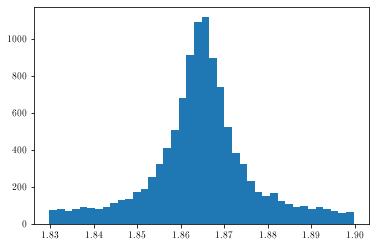

In [2]:
h[h_c,'p'] = kinematics.calc_p(h,h_c)
p_cut = h[h_c,"p"] > 0.
h = h[p_cut]

pi_cut = abs(h[h_c,"mass"] - lp.pi_plus.mass/1000.) < 1e-4
h["pi"] = h[h_c][pi_cut]

k_cut = abs(h[h_c,"mass"] - lp.K_plus.mass/1000.) < 1e-4
h["k"] = h[h_c][k_cut]

D = ak.cartesian({"k": h["k"], "pi": h["pi"]})
D_cut = np.sign(D["k","charge"]) != np.sign(D["pi","charge"])
D = D[D_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D["mass"] = kinematics.mass([D["k"], D["pi"]], [PDG_K_m, PDG_pi_m])

PDG_D_m = lp.D_0.mass/1000.
D_cut = abs(D["mass"] - PDG_D_m) < 0.035
D = D[D_cut]

plt.hist(ak.flatten(D["mass"]),bins=40)
plt.show()

Build $B^\pm \to D^0 \pi^\pm$ candidates, keeping only those where the $K$ from the $D^0$ has the same charge as the $\pi$ produced in the $B^\pm$ decay:

In [3]:
B = ak.cartesian({"D_k": D["k"], "D_pi": D["pi"], "pi": h["pi"]})
B_cut = np.sign(B["D_k","charge"]) == np.sign(B["pi","charge"])
B = B[B_cut]
B["mass"] = kinematics.mass([B["D_k"], B["D_pi"], B["pi"]], [PDG_K_m, PDG_pi_m, PDG_pi_m])

Keep $B^\pm$ candidates within a certain mass range and plot:

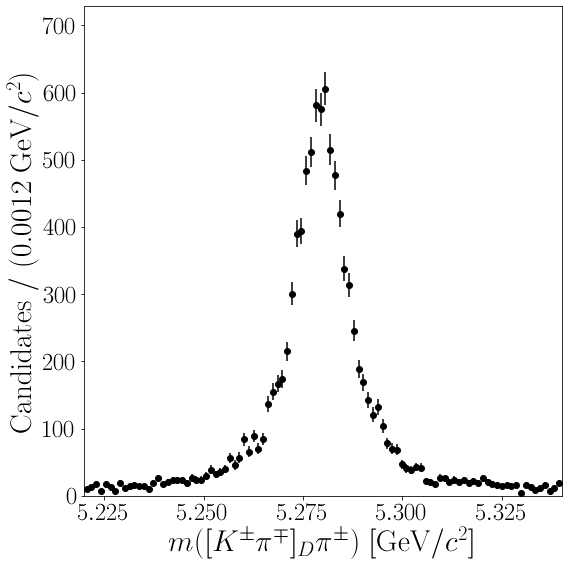

In [4]:
low = 5.22
high = 5.34
B_cut = np.logical_and(B["mass"] > low, B["mass"] < high)
B = B[B_cut]

plotting.errorbar_hist(B,"mass","B","$m([K^\pm \pi^\mp]_D \pi^\pm)$","GeV/$c^2$",low,high,100)

Fit the distribution with zfit, including a signal peak component and an exponential component for random combinations:

In [5]:
obs = zfit.Space('mB', limits=(low, high))

#Signal PDF
B_mu = zfit.Parameter("B_mu", 5.279, low, high)
B_sigma = zfit.Parameter("B_sigma", 0.007, 0., 0.1)
B_alphaL = zfit.Parameter("B_alphaL", 0.2, 0., 5.)
B_nL = zfit.Parameter("B_nL", 0.1, 0., 200.)
B_alphaR = zfit.Parameter("B_alphaR", -0.2, -5., 0.)
B_nR = zfit.Parameter("B_nR", 0.1, 0., 200.)
frac = zfit.Parameter("frac", 0.5, 0., 1.)

n_sig = zfit.Parameter("n_sig", 9000, 0., 10000.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaL, n=B_nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaR, n=B_nR)
pdf_sig = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac).create_extended(n_sig)

#Background PDF
comb = zfit.Parameter("comb", 0.0, -1, 1.)

n_bkg = zfit.Parameter("n_bkg", 1000., 0., 10000.)

pdf_bkg = zfit.pdf.Chebyshev(obs=obs, coeffs=[comb]).create_extended(n_bkg)

#Total PDF
pdf = zfit.pdf.SumPDF([pdf_sig, pdf_bkg])

In [6]:
data_np = ak.to_numpy(ak.flatten(B["mass"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [7]:
nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit(tolerance=1e-5)
result = minimizer.minimize(nll)
param_errors, _ = result.errors(method="minuit_minos")

print("m(B) fit function minimum:", result.fmin)
print("m(B) fit converged:", result.converged)
print("m(B) fit full minimizer information:", result.info)

params = result.params
print(params)

/eos/user/d/dhill/.local/lib/python3.7/site-packages/zfit/models/polynomials.py:27: UserWarning: The function <function Space.limit1d at 0x7f84e804ac20> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('mB',), axes=(0,), limits=(array([[5.22]]), array([[5.34]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  lim_low, lim_high = limits.limit1d
/eos/user/d/dhill/.local/lib/python3.7/site-packages/zfit/models/polynomials.py:276: UserWarning: The function <function Space.area at 0x7f84e804a9e0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('mB',), axes=(0,), limits=(array([[5.22]]), array([[5.34]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  integral *= 0.5 * model.space.area()  # resca

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.107e+05                 │      Ncalls = 1749 (1749 total)      │
│ EDM = 2.63e-08 (Goal: 1e-05)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(B) fit function minimum: -110669.82070332566
m(B) fit converged: True
m(B) fit full minimizer information: {'n_eval': 1749, 'n_iter': 1749, 'original': FMin(fval=-110669.82070332566, edm=2.62761960073734e-08, tolerance=0.01, nfcn=1749, nc

Plot the fit result:

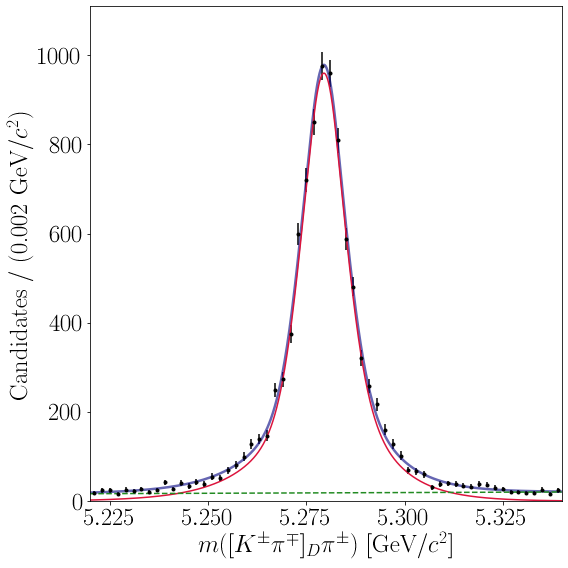

In [20]:
fig,ax = plt.subplots(figsize=(8,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.002
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
y_plot_sig = zfit.run(pdf_sig.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_sig*params[n_sig]['value']/bins*obs.area(), color='crimson')
y_plot_bkg = zfit.run(pdf_bkg.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_bkg*params[n_bkg]['value']/bins*obs.area(), color='forestgreen', linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m([K^\pm \pi^\mp]_D \pi^\pm)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.tight_layout()
fig.savefig(loc.PLOTS+"/Bu2D0Pi_fit.pdf")